# 🧠 Content Moderation ML Pipeline

Complete training pipeline for multimodal content moderation using Vision Transformer (ViT) and DistilBERT.

## 1. Setup and Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print(f"✅ PyTorch version: {torch.__version__}")

✅ Using device: cpu
✅ PyTorch version: 2.9.0


## 2. Dataset Details and Exploration

In [2]:
# Load dataset
dataset_path = '../data/dataset.csv'
images_dir = '../data/images'

df = pd.read_csv(dataset_path)
print(f"📊 Dataset Overview:")
print(f"   Total entries: {len(df)}")
print(f"   Columns: {list(df.columns)}")
print(f"\n📈 Label Distribution:")
print(df['label'].value_counts())
print(f"\n📊 Label Percentages:")
print(df['label'].value_counts(normalize=True) * 100)

📊 Dataset Overview:
   Total entries: 1740
   Columns: ['image_path', 'title', 'description', 'label']

📈 Label Distribution:
label
safe       1140
drugs       300
alcohol     200
weapon      100
Name: count, dtype: int64

📊 Label Percentages:
label
safe       65.517241
drugs      17.241379
alcohol    11.494253
weapon      5.747126
Name: proportion, dtype: float64


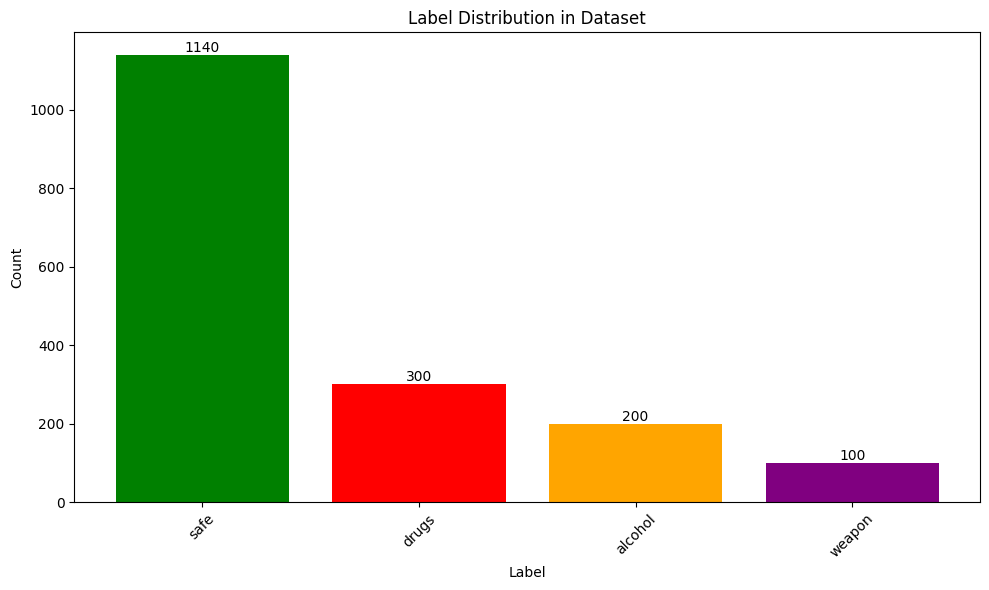

In [3]:
# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values, color=['green', 'red', 'orange', 'purple'])
plt.title('Label Distribution in Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, v in enumerate(label_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [4]:
# Check text statistics
df['title_length'] = df['title'].str.len()
df['description_length'] = df['description'].str.len()

print(f"📝 Text Statistics:")
print(f"   Title length - Mean: {df['title_length'].mean():.1f}, Max: {df['title_length'].max()}, Min: {df['title_length'].min()}")
print(f"   Description length - Mean: {df['description_length'].mean():.1f}, Max: {df['description_length'].max()}, Min: {df['description_length'].min()}")

# Sample entries
print(f"\n📋 Sample Entries:")
for label in df['label'].unique():
    sample = df[df['label'] == label].iloc[0]
    print(f"\n   [{label.upper()}]")
    print(f"   Title: {sample['title']}")
    print(f"   Description: {sample['description'][:100]}...")

📝 Text Statistics:
   Title length - Mean: 15.1, Max: 203, Min: 1
   Description length - Mean: 60.4, Max: 253, Min: 34

📋 Sample Entries:

   [SAFE]
   Title: Cycles 43
   Description: This is a cycles 43 in good condition, available for sale....

   [DRUGS]
   Title: medicines 30
   Description: Item related to drugs or medicines: medicines 30...

   [WEAPON]
   Title: s 79
   Description: Item related to weapons or dangerous items: weapons 79...

   [ALCOHOL]
   Title: 46
   Description: Item related to alcohol: alcohol 46...


In [5]:
# Check image availability
from pathlib import Path
images_path = Path(images_dir)
available_images = list(images_path.glob('*.jpg')) + list(images_path.glob('*.png')) + list(images_path.glob('*.webp'))
print(f"🖼️  Image Statistics:")
print(f"   Total images in directory: {len(available_images)}")
print(f"   Images referenced in CSV: {len(df)}")

# Check for missing images
missing = 0
for idx, row in df.iterrows():
    img_name = row['image_path'].replace('images/', '')
    if not (images_path / img_name).exists():
        missing += 1
        if missing <= 5:
            print(f"   ⚠️  Missing: {img_name}")

if missing > 0:
    print(f"   ⚠️  Total missing images: {missing}")
else:
    print(f"   ✅ All images found!")

🖼️  Image Statistics:
   Total images in directory: 3440
   Images referenced in CSV: 1740
   ✅ All images found!


## 3. Data Preprocessing

In [6]:
from modeling.dataset import ModerationDataset

# Create dataset
full_dataset = ModerationDataset(
    csv_path=dataset_path,
    images_dir=images_dir,
    tokenizer_name='distilbert-base-uncased',
    max_length=128
)

print(f"✅ Dataset created: {len(full_dataset)} samples")
print(f"✅ Label mapping: {full_dataset.label_to_idx}")

✅ Dataset created: 1740 samples
✅ Label mapping: {'safe': 0, 'weapon': 1, 'alcohol': 2, 'drugs': 3}


In [7]:
# Train/Validation/Test split (70/15/15)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"📊 Dataset Split:")
print(f"   Train: {len(train_dataset)} samples ({len(train_dataset)/len(full_dataset)*100:.1f}%)")
print(f"   Validation: {len(val_dataset)} samples ({len(val_dataset)/len(full_dataset)*100:.1f}%)")
print(f"   Test: {len(test_dataset)} samples ({len(test_dataset)/len(full_dataset)*100:.1f}%)")

📊 Dataset Split:
   Train: 1218 samples (70.0%)
   Validation: 261 samples (15.0%)
   Test: 261 samples (15.0%)


In [14]:
# Create data loaders
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"✅ Data loaders created with batch size: {batch_size}")

✅ Data loaders created with batch size: 64


In [15]:
# Test data loading
sample_batch = next(iter(train_loader))
print(f"📦 Sample Batch:")
print(f"   Images shape: {sample_batch['image'].shape}")
print(f"   Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"   Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"   Labels shape: {sample_batch['label'].shape}")
print(f"   Sample label: {sample_batch['label'][0].item()} ({full_dataset.idx_to_label[sample_batch['label'][0].item()]})")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📦 Sample Batch:
   Images shape: torch.Size([64, 3, 224, 224])
   Input IDs shape: torch.Size([64, 128])
   Attention mask shape: torch.Size([64, 128])
   Labels shape: torch.Size([64])
   Sample label: 3 (drugs)


## 4. Model Architecture

In [16]:
from modeling.multimodal_model import MultimodalModerationModel

# Initialize model
num_classes = 4  # safe, weapon, alcohol, drugs
model = MultimodalModerationModel(
    num_classes=num_classes,
    image_model_name='vit_base_patch16_224',
    text_model_name='distilbert-base-uncased',
    dropout=0.3
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model created:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB (float32)")

✅ Model created:
   Total parameters: 153,080,836
   Trainable parameters: 153,080,836
   Model size: ~584.0 MB (float32)


In [17]:
# Test forward pass
model.eval()
with torch.no_grad():
    sample_image = sample_batch['image'][:2].to(device)
    sample_text = {
        'input_ids': sample_batch['input_ids'][:2].to(device),
        'attention_mask': sample_batch['attention_mask'][:2].to(device)
    }
    
    output = model(sample_image, sample_text)
    print(f"✅ Forward pass test:")
    print(f"   Input: 2 samples")
    print(f"   Output shape: {output.shape}")
    print(f"   Output logits: {output}")
    
    probs = torch.softmax(output, dim=1)
    preds = torch.argmax(probs, dim=1)
    print(f"   Predictions: {[full_dataset.idx_to_label[p.item()] for p in preds]}")
    print(f"   Probabilities: {probs}")

✅ Forward pass test:
   Input: 2 samples
   Output shape: torch.Size([2, 4])
   Output logits: tensor([[ 0.0782,  0.1077, -0.1258,  0.1770],
        [ 0.1538,  0.1137, -0.1582,  0.1190]])
   Predictions: ['drugs', 'safe']
   Probabilities: tensor([[0.2532, 0.2608, 0.2065, 0.2795],
        [0.2733, 0.2626, 0.2001, 0.2640]])


## 5. Training Configuration

In [18]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, 
)

# Training hyperparameters
num_epochs = 10
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

print(f"✅ Training Configuration:")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: AdamW (lr=2e-5, weight_decay=0.01)")
print(f"   Scheduler: ReduceLROnPlateau")
print(f"   Epochs: {num_epochs}")
print(f"   Early stopping patience: {early_stopping_patience}")

✅ Training Configuration:
   Loss function: CrossEntropyLoss
   Optimizer: AdamW (lr=2e-5, weight_decay=0.01)
   Scheduler: ReduceLROnPlateau
   Epochs: 10
   Early stopping patience: 5


## 6. Training Loop

In [19]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"🚀 Starting training...")
print(f"=" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for batch in train_pbar:
        images = batch['image'].to(device)
        text_inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, text_inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100 * train_correct / train_total:.2f}%"
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for batch in val_pbar:
            images = batch['image'].to(device)
            text_inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            labels = batch['label'].to(device)
            
            outputs = model(images, text_inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100 * val_correct / val_total:.2f}%"
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    
    # Update history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        
        # Save model
        os.makedirs('../models', exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'val_acc': val_acc,
            'label_to_idx': full_dataset.label_to_idx,
            'idx_to_label': full_dataset.idx_to_label
        }, '../models/best_model.pt')
        print(f"  ✅ Saved best model (val_loss: {avg_val_loss:.4f})")
    else:
        patience_counter += 1
        
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\n⏹️  Early stopping triggered after {epoch+1} epochs")
        break
    
    print(f"-" * 60)

print(f"\n✅ Training completed!")

🚀 Starting training...


Epoch 1/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/10 [Train]: 100%|█| 20/20 [04:42<00:00, 14.13s/it, loss=0.1031, acc=66.8
Epoch 1/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 1/10:
  Train Loss: 0.8370, Train Acc: 66.83%
  Val Loss: 0.3793, Val Acc: 93.49%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.3793)
------------------------------------------------------------


Epoch 2/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 2/10 [Train]: 100%|█| 20/20 [04:40<00:00, 14.01s/it, loss=0.0106, acc=96.6
Epoch 2/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 2/10:
  Train Loss: 0.2272, Train Acc: 96.63%
  Val Loss: 0.0909, Val Acc: 98.47%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0909)
------------------------------------------------------------


Epoch 3/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 3/10 [Train]: 100%|█| 20/20 [04:42<00:00, 14.13s/it, loss=0.0129, acc=99.7
Epoch 3/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 3/10:
  Train Loss: 0.0524, Train Acc: 99.75%
  Val Loss: 0.0186, Val Acc: 99.62%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0186)
------------------------------------------------------------


Epoch 4/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 4/10 [Train]: 100%|█| 20/20 [04:46<00:00, 14.30s/it, loss=0.0005, acc=100.
Epoch 4/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 4/10:
  Train Loss: 0.0104, Train Acc: 100.00%
  Val Loss: 0.0031, Val Acc: 100.00%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0031)
------------------------------------------------------------


Epoch 5/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 5/10 [Train]: 100%|█| 20/20 [04:47<00:00, 14.36s/it, loss=0.0091, acc=100.
Epoch 5/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 5/10:
  Train Loss: 0.0048, Train Acc: 100.00%
  Val Loss: 0.0016, Val Acc: 100.00%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0016)
------------------------------------------------------------


Epoch 6/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 6/10 [Train]: 100%|█| 20/20 [04:42<00:00, 14.14s/it, loss=0.0002, acc=100.
Epoch 6/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 6/10:
  Train Loss: 0.0024, Train Acc: 100.00%
  Val Loss: 0.0011, Val Acc: 100.00%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0011)
------------------------------------------------------------


Epoch 7/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 7/10 [Train]: 100%|█| 20/20 [04:53<00:00, 14.68s/it, loss=0.0007, acc=100.
Epoch 7/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 7/10:
  Train Loss: 0.0018, Train Acc: 100.00%
  Val Loss: 0.0007, Val Acc: 100.00%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0007)
------------------------------------------------------------


Epoch 8/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 8/10 [Train]: 100%|█| 20/20 [04:46<00:00, 14.33s/it, loss=0.0044, acc=100.
Epoch 8/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 8/10:
  Train Loss: 0.0015, Train Acc: 100.00%
  Val Loss: 0.0006, Val Acc: 100.00%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0006)
------------------------------------------------------------


Epoch 9/10 [Train]:   0%|                                | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 9/10 [Train]: 100%|█| 20/20 [04:56<00:00, 14.82s/it, loss=0.0012, acc=100.
Epoch 9/10 [Val]:   0%|                                   | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 9/10:
  Train Loss: 0.0013, Train Acc: 100.00%
  Val Loss: 0.0005, Val Acc: 100.00%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0005)
------------------------------------------------------------


Epoch 10/10 [Train]:   0%|                               | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 10/10 [Train]: 100%|█| 20/20 [04:53<00:00, 14.65s/it, loss=0.0002, acc=100
Epoch 10/10 [Val]:   0%|                                  | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling


Epoch 10/10:
  Train Loss: 0.0008, Train Acc: 100.00%
  Val Loss: 0.0004, Val Acc: 100.00%
  LR: 2.00e-05
  ✅ Saved best model (val_loss: 0.0004)
------------------------------------------------------------

✅ Training completed!


## 7. Training History Visualization

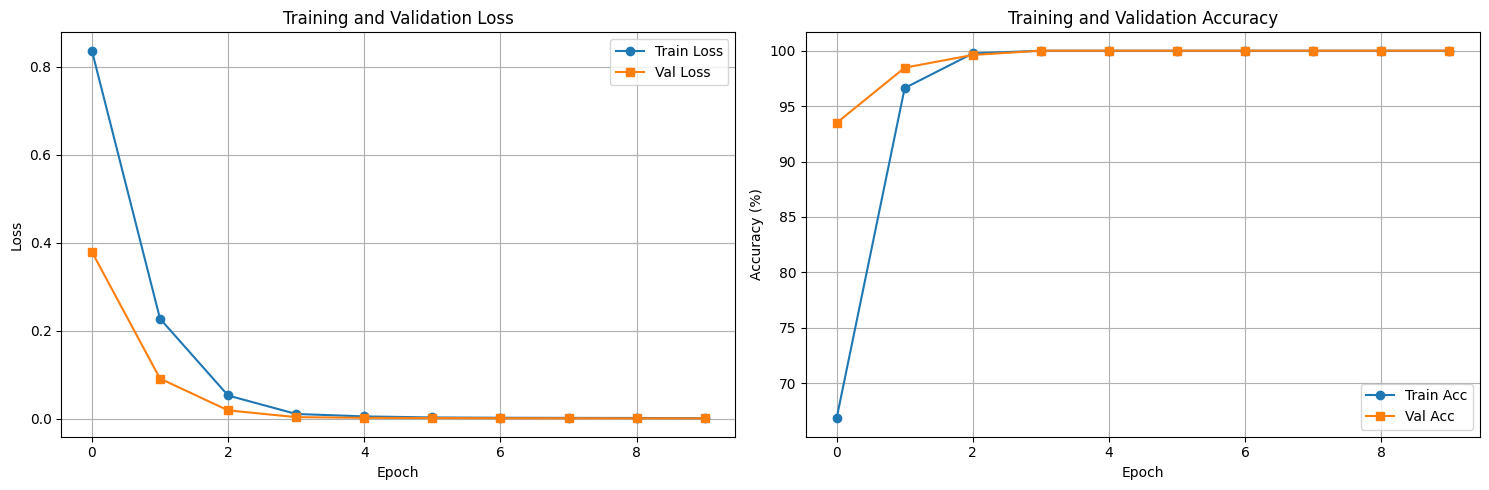

In [20]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 8. Load Best Model and Evaluate

In [21]:
# Load best model
checkpoint = torch.load('../models/best_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"   Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"   Validation Accuracy: {checkpoint['val_acc']:.2f}%")

✅ Loaded best model from epoch 10
   Validation Loss: 0.0004
   Validation Accuracy: 100.00%


In [22]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Evaluating on Test Set")
    for batch in test_pbar:
        images = batch['image'].to(device)
        text_inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        labels = batch['label'].to(device)
        
        outputs = model(images, text_inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)

print(f"\n📊 Test Set Evaluation:")
print(f"   Overall Accuracy: {accuracy*100:.2f}%")
print(f"\n   Per-Class Metrics:")
for i, label in enumerate(['safe', 'weapon', 'alcohol', 'drugs']):
    print(f"   {label:10s} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}, Support: {support[i]}")

Evaluating on Test Set:   0%|                             | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating on Test Set: 100%|█████████████████████| 5/5 [00:30<00:00,  6.04s/it]


📊 Test Set Evaluation:
   Overall Accuracy: 100.00%

   Per-Class Metrics:
   safe       - Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Support: 173
   weapon     - Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Support: 14
   alcohol    - Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Support: 32
   drugs      - Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Support: 42


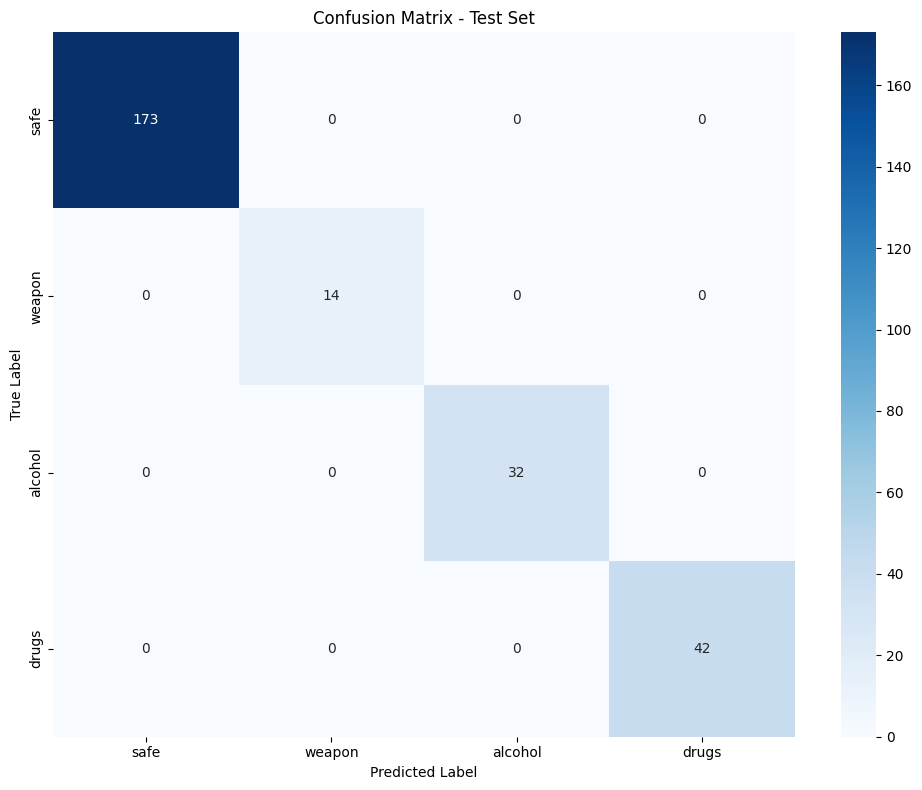

In [23]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['safe', 'weapon', 'alcohol', 'drugs'],
            yticklabels=['safe', 'weapon', 'alcohol', 'drugs'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [24]:
# Classification Report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, 
                            target_names=['safe', 'weapon', 'alcohol', 'drugs']))


📋 Classification Report:
              precision    recall  f1-score   support

        safe       1.00      1.00      1.00       173
      weapon       1.00      1.00      1.00        14
     alcohol       1.00      1.00      1.00        32
       drugs       1.00      1.00      1.00        42

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261



## 9. Save Final Model

In [28]:
# Save final model for API deployment
final_model_path = '../models/model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'label_to_idx': full_dataset.label_to_idx,
    'idx_to_label': full_dataset.idx_to_label,
    'num_classes': num_classes,
    'test_accuracy': accuracy,
    'test_precision': precision.tolist(),
    'test_recall': recall.tolist(),
    'test_f1': f1.tolist()
}, final_model_path)

print(f"✅ Final model saved to: {final_model_path}")
print(f"   Model size: {os.path.getsize(final_model_path) / 1024 / 1024:.2f} MB")
print(f"   Test Accuracy: {accuracy*100:.2f}%")
print(f"\n🎉 Model training complete! Ready for deployment.")

✅ Final model saved to: ../models/model.pt
   Model size: 584.04 MB
   Test Accuracy: 100.00%

🎉 Model training complete! Ready for deployment.


## 10. Test Model on Sample Images

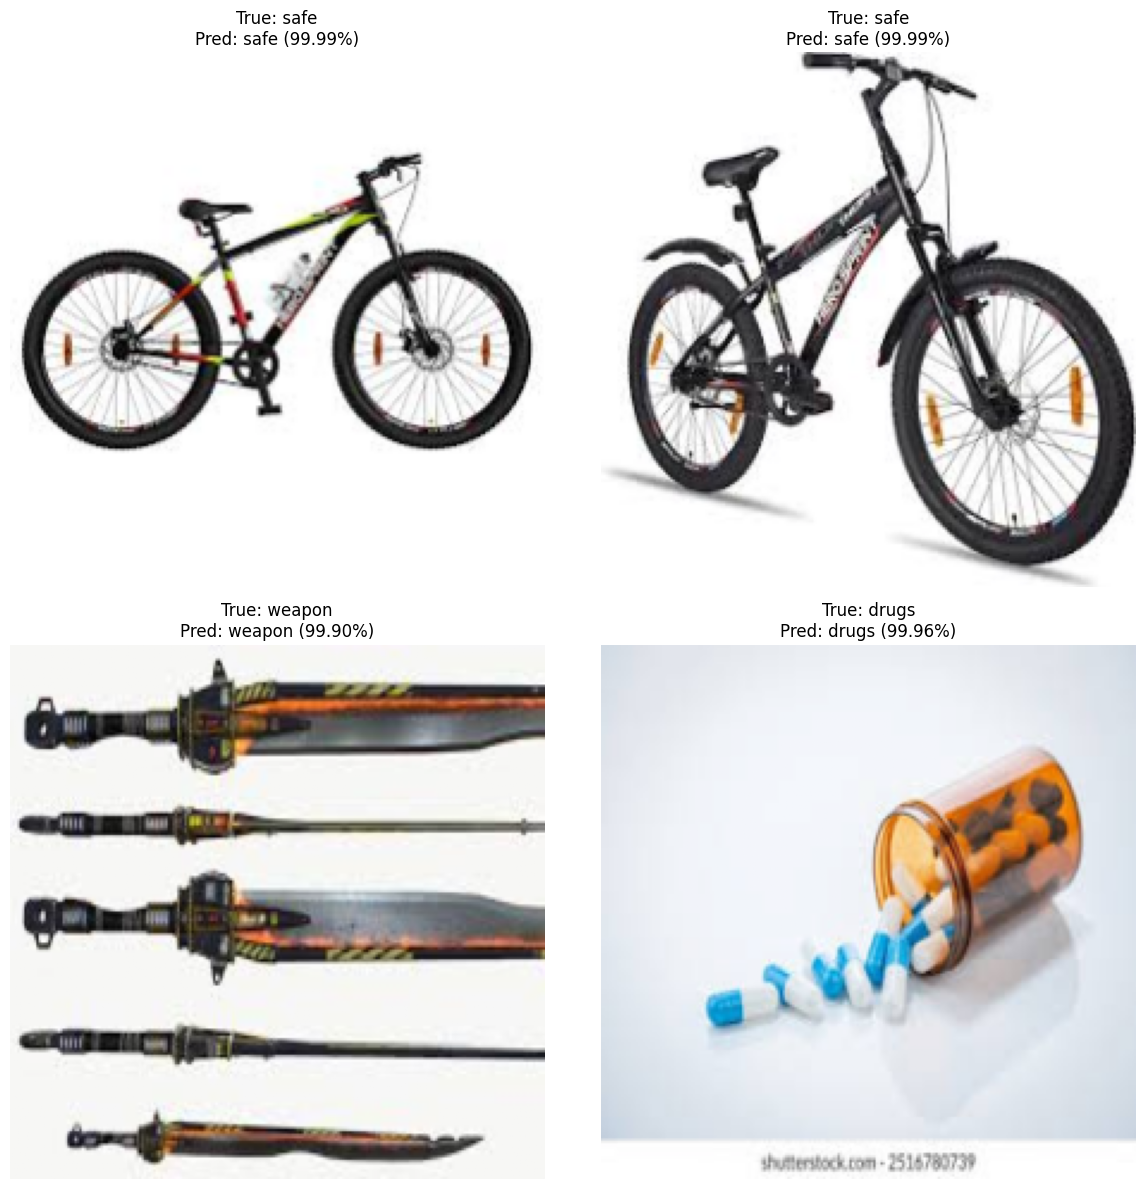

In [29]:
# Test on a few sample images
model.eval()
sample_indices = [0, 100, 1340, 1140]  # Mixed: 2 safe, 1 weapon, 1 prohibited

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    sample = full_dataset[sample_idx]
    
    # Get prediction
    with torch.no_grad():
        image = sample['image'].unsqueeze(0).to(device)
        text_inputs = {
            'input_ids': sample['input_ids'].unsqueeze(0).to(device),
            'attention_mask': sample['attention_mask'].unsqueeze(0).to(device)
        }
        
        output = model(image, text_inputs)
        probs = torch.softmax(output, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_idx].item()
        
        true_label = full_dataset.idx_to_label[sample['label'].item()]
        pred_label = full_dataset.idx_to_label[pred_idx]
    
    # Display image
    img = sample['image'].permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    
    axes[idx].imshow(img.numpy())
    axes[idx].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2%})")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()